In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-multimodal-image-ct-and-mri' dataset.
Path to dataset files: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import random


In [ ]:
for subdir, dirs, files in os.walk(path):
    print(f"{subdir} → {len(files)} files")

/kaggle/input/brain-tumor-multimodal-image-ct-and-mri → 0 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset → 0 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images → 1 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Tumor → 3000 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Healthy → 2000 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images → 1 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images/Tumor → 2318 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images/Healthy → 2300 files


In [ ]:

def count_images(root):
    stats = {}
    dataset_path = os.path.join(root, "Dataset")

    for modality in os.listdir(dataset_path):
        modality_path = os.path.join(dataset_path, modality)

        if os.path.isdir(modality_path):
            stats[modality] = {}

            # list Tumor / Healthy folders
            for label in os.listdir(modality_path):
                label_path = os.path.join(modality_path, label)

                if os.path.isdir(label_path):
                    num_images = len([
                        f for f in os.listdir(label_path)
                        if f.lower().endswith((".jpg", ".png", ".jpeg"))
                    ])
                    stats[modality][label] = num_images

    return stats

stats = count_images(path)
stats

{'Brain Tumor MRI images': {'Tumor': 3000, 'Healthy': 2000},
 'Brain Tumor CT scan Images': {'Tumor': 2318, 'Healthy': 2300}}

In [ ]:
rows = []
for modality, labels in stats.items():
    for label, count in labels.items():
        rows.append({
            "modality": modality,
            "label": label,
            "count": count
        })

df_counts = pd.DataFrame(rows)
df_counts

,modality,label,count
0,Brain Tumor MRI images,Tumor,3000
1,Brain Tumor MRI images,Healthy,2000
2,Brain Tumor CT scan Images,Tumor,2318
3,Brain Tumor CT scan Images,Healthy,2300


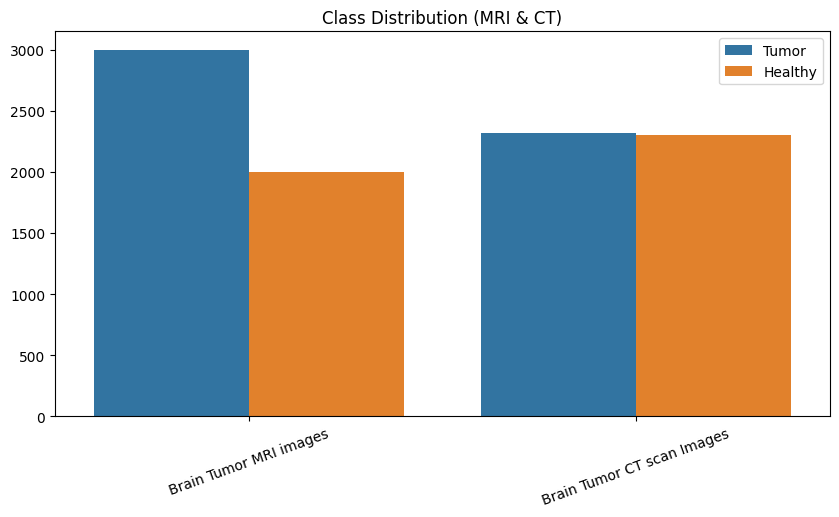

In [ ]:
flat = []
for modality, label_dict in stats.items():
    for label, count in label_dict.items():
        flat.append((modality, label, count))

modality, label, count = zip(*flat)

plt.figure(figsize=(10,5))
sns.barplot(x=modality, y=count, hue=label)
plt.xticks(rotation=20)
plt.title("Class Distribution (MRI & CT)")
plt.show()

We verified the directory structure and confirmed the dataset is well-organized, with clear separation between modalities (CT vs. MRI) and labels (tumor vs. healthy). Both modalities are nearly balanced between tumor and healthy cases, reducing the risk of label bias. MRI contains slightly more samples overall, but both datasets are suitable for learning.

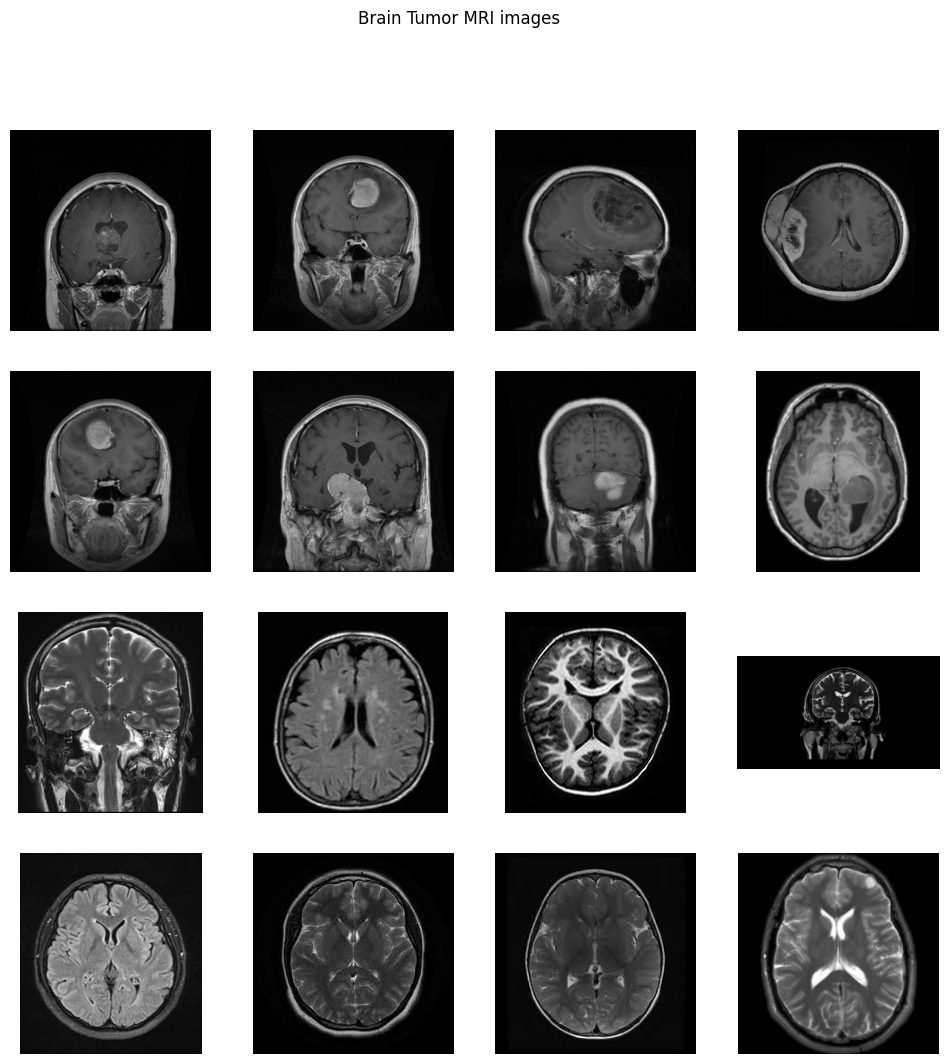

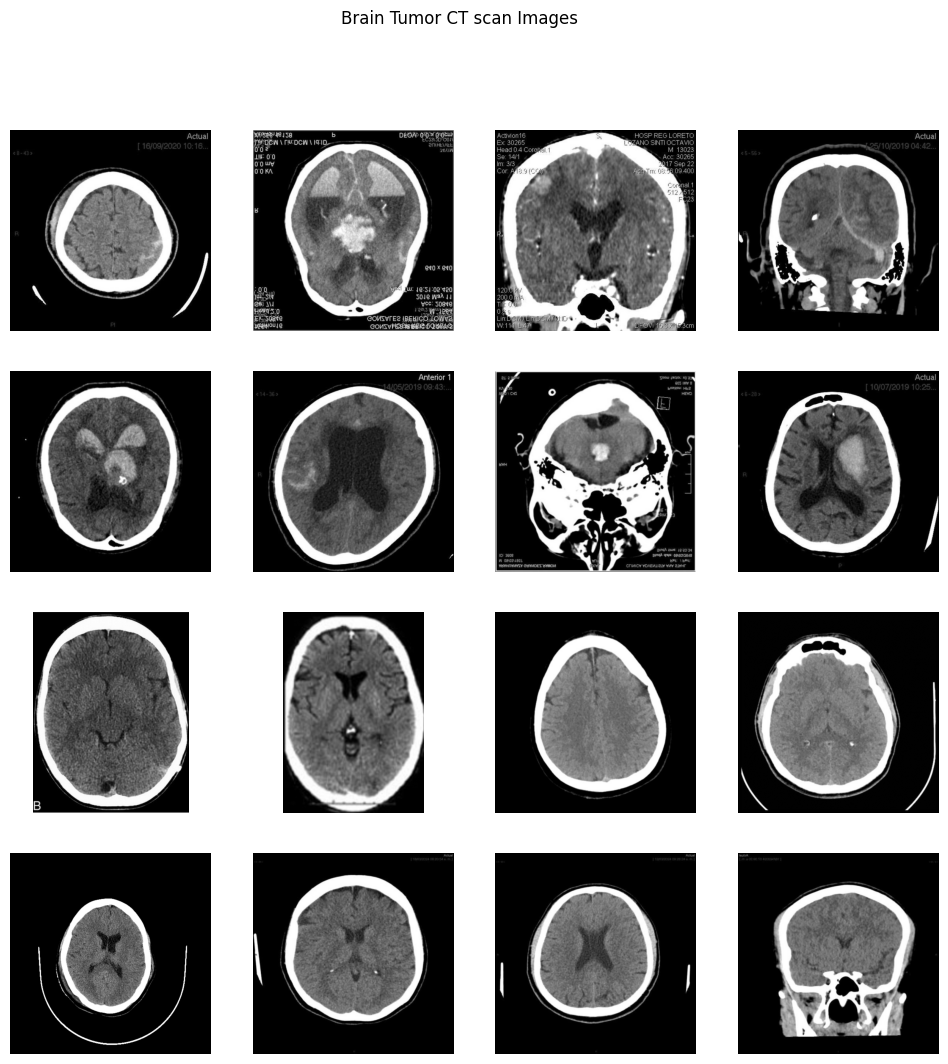

In [ ]:
def grid_show(root, modality, n=16):
    modality_path = os.path.join(root, "Dataset", modality)
    files = []

    for label in os.listdir(modality_path):
        label_path = os.path.join(modality_path, label)
        if os.path.isdir(label_path):
            images = [
                os.path.join(label_path, f)
                for f in os.listdir(label_path)
                if f.lower().endswith((".jpg",".png",".jpeg"))
            ]
            files.extend(random.sample(images, min(len(images), n//2)))

    plt.figure(figsize=(12,12))
    for i, img_path in enumerate(files[:n]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(4,4,i+1)
        plt.imshow(img, cmap="gray")
        plt.axis('off')
    plt.suptitle(modality)
    plt.show()

grid_show(path, "Brain Tumor MRI images")
grid_show(path, "Brain Tumor CT scan Images")


Visualizing sample grids from each modality immediately revealed substantial differences in image quality:
*   MRI scans appear high-resolution with clear structural anatomy and consistent contrast across patients.
*   CT scans, however, are noticeably lower resolution, vary widely in brightness, and appear to have been cropped or downsampled before inclusion in the Kaggle dataset.

This early inspection highlighted that MRI likely contains richer spatial information for classification, while CT may require heavier preprocessing (e.g., resizing, normalization, contrast adjustment).

In [ ]:
def get_sizes_modality_pil(root, modality):
    widths, heights = []
    modality_path = os.path.join(root, "Dataset", modality)

    widths = []
    heights = []

    for label in os.listdir(modality_path):
        label_path = os.path.join(modality_path, label)

        if not os.path.isdir(label_path):
            continue

        for f in os.listdir(label_path):
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                try:
                    img = Image.open(os.path.join(label_path, f))
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                except:
                    continue
    return widths, heights

In [ ]:
df_mri_sizes = pd.DataFrame({
    "width": mri_w,
    "height": mri_h,
    "modality": "MRI"
})

df_ct_sizes = pd.DataFrame({
    "width": ct_w,
    "height": ct_h,
    "modality": "CT"
})

df_sizes = pd.concat([df_mri_sizes, df_ct_sizes], ignore_index=True)


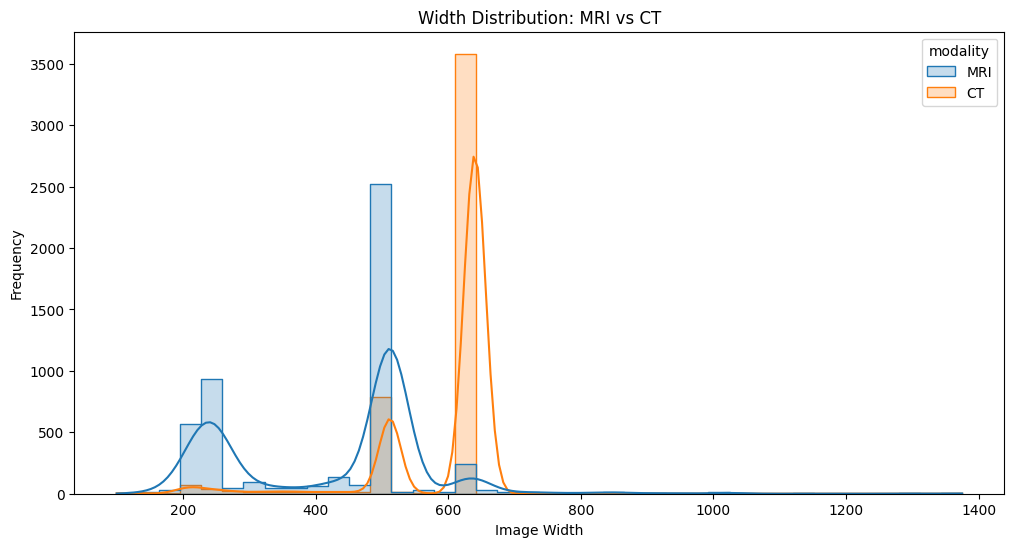

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(data=df_sizes, x="width", hue="modality", bins=40, kde=True, element="step")
plt.title("Width Distribution: MRI vs CT")
plt.xlabel("Image Width")
plt.ylabel("Frequency")
plt.show()


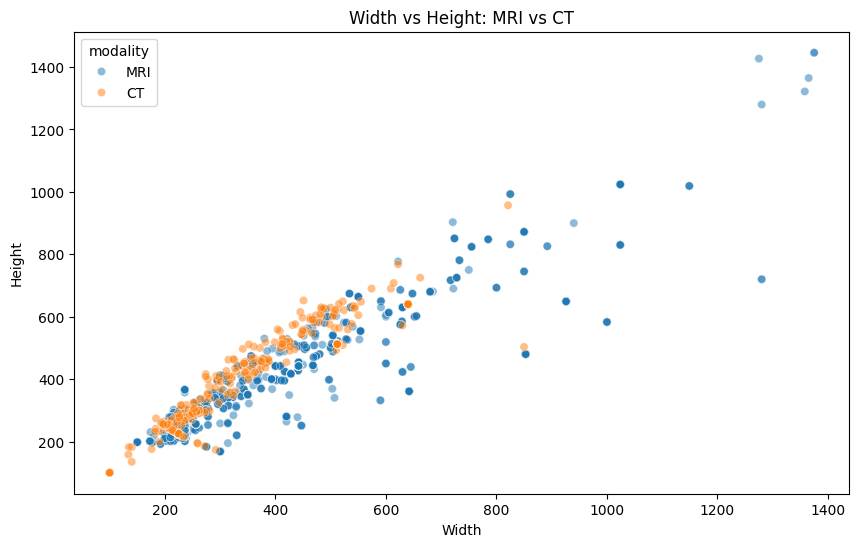

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_sizes,
    x="width",
    y="height",
    hue="modality",
    alpha=0.5
)
plt.title("Width vs Height: MRI vs CT")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


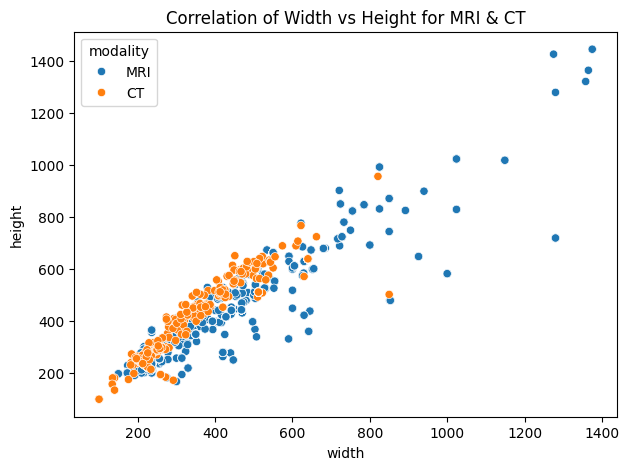

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_sizes, x="width", y="height", hue="modality")
plt.title("Correlation of Width vs Height for MRI & CT")
plt.show()

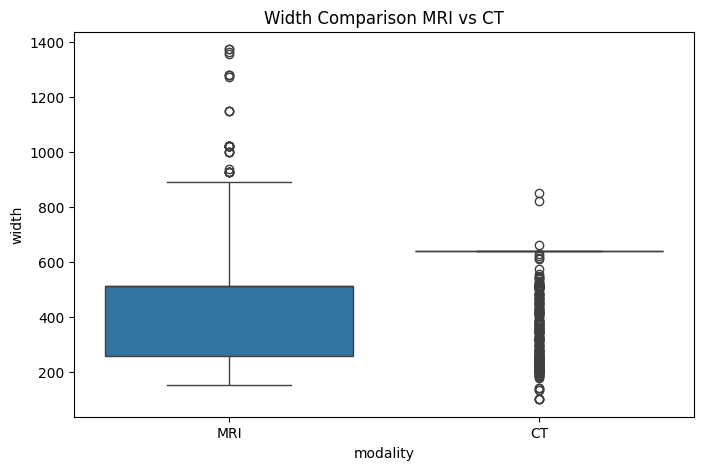

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_sizes, x="modality", y="width")
plt.title("Width Comparison MRI vs CT")
plt.show()


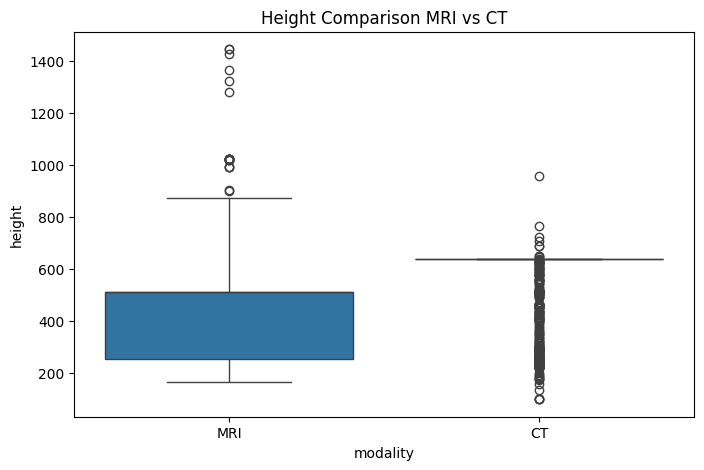

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_sizes, x="modality", y="height")
plt.title("Height Comparison MRI vs CT")
plt.show()


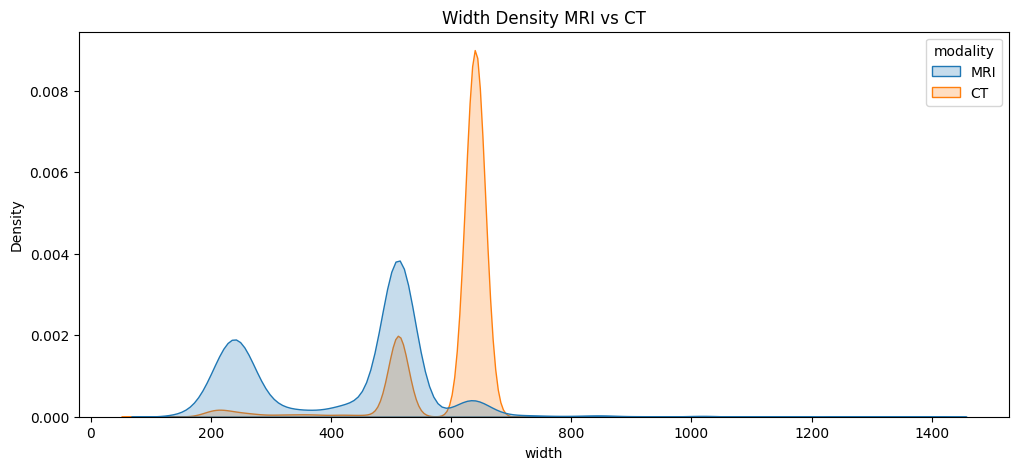

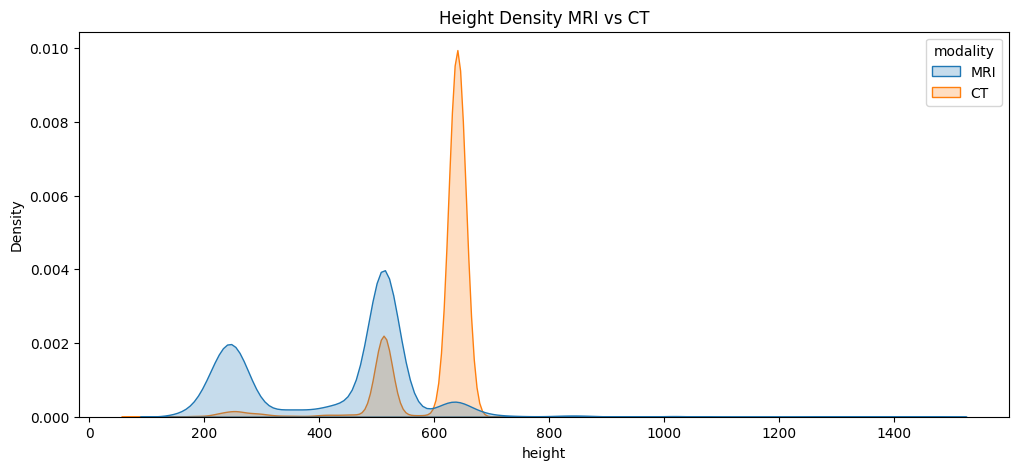

In [ ]:
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_sizes, x="width", hue="modality", fill=True)
plt.title("Width Density MRI vs CT")
plt.show()

plt.figure(figsize=(12,5))
sns.kdeplot(data=df_sizes, x="height", hue="modality", fill=True)
plt.title("Height Density MRI vs CT")
plt.show()


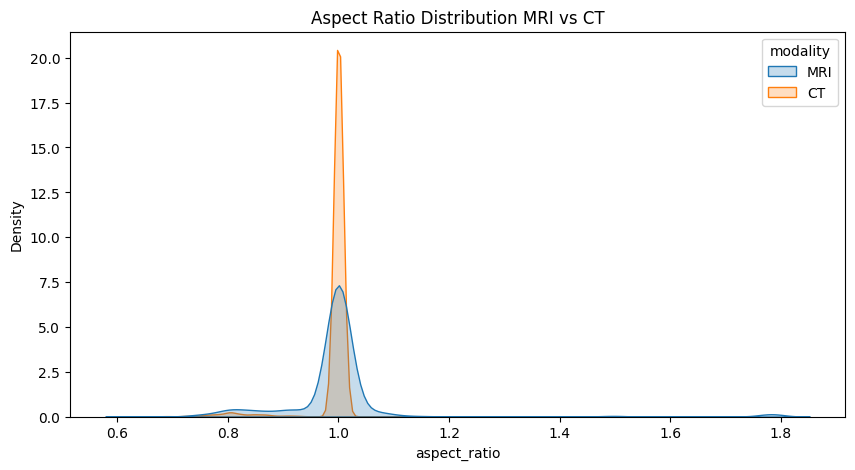

In [ ]:
df_sizes["aspect_ratio"] = df_sizes["width"] / df_sizes["height"]

plt.figure(figsize=(10,5))
sns.kdeplot(
    data=df_sizes,
    x="aspect_ratio",
    hue="modality",
    fill=True
)
plt.title("Aspect Ratio Distribution MRI vs CT")
plt.show()


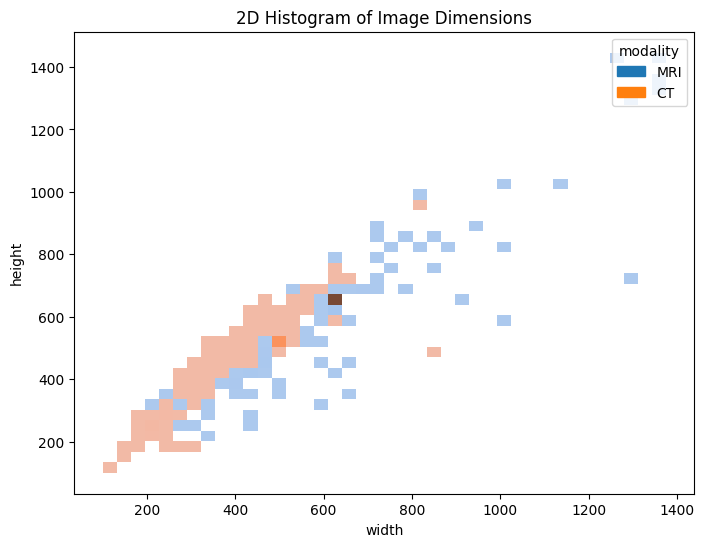

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df_sizes, x="width", y="height", hue="modality", bins=40)
plt.title("2D Histogram of Image Dimensions")
plt.show()


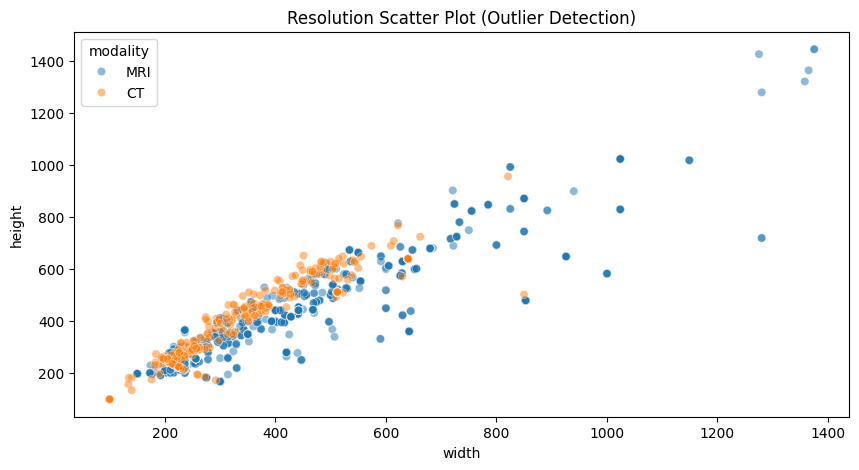

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df_sizes,
    x="width",
    y="height",
    hue="modality",
    alpha=0.5
)
plt.title("Resolution Scatter Plot (Outlier Detection)")
plt.show()


MRI scans

*   Width and height range approximately from 200 to 1400 pixels.
*   Aspect ratios cluster consistently around medically typical values.
*   Variability suggests the images come from real clinical MRI machines.

CT scans
*   Width and height are significantly smaller, generally between 100 and 230 pixels.
*   Aspect ratios show irregular patterns, indicating inconsistent cropping or resizing.
*   Image quality suggests these are thumbnails, not full-resolution CT slices (which are normally 512×512).


This resolution analysis is crucial for selecting input tensor sizes and designing preprocessing pipelines that do not distort tumor features.

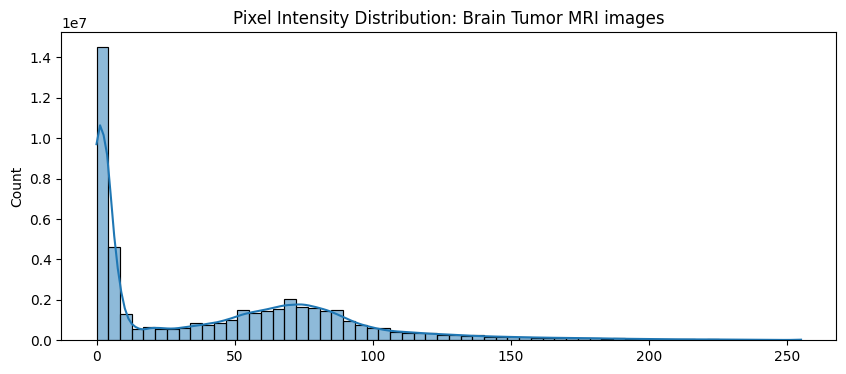

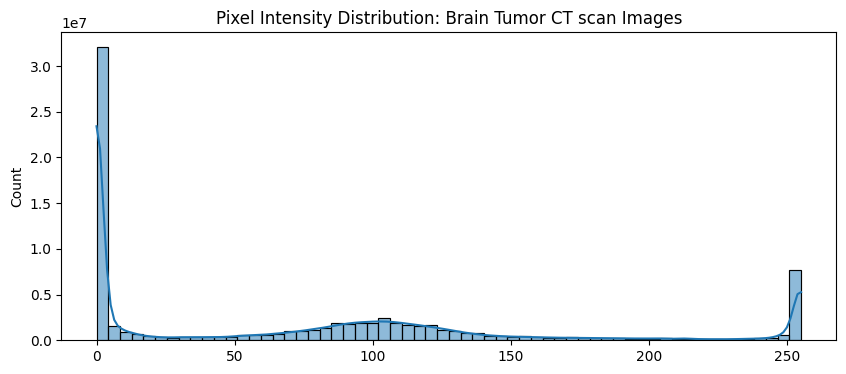

In [ ]:
def intensity_hist(root, modality, n=200):
    modality_path = os.path.join(root, "Dataset", modality)
    values = []

    count = 0
    for label in os.listdir(modality_path):
        label_path = os.path.join(modality_path, label)
        if not os.path.isdir(label_path):
            continue

        for f in os.listdir(label_path):
            if f.lower().endswith((".jpg",".png",".jpeg")):
                img = cv2.imread(os.path.join(label_path, f), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    values.extend(img.flatten())
                count += 1
                if count >= n:
                    break

    plt.figure(figsize=(10,4))
    sns.histplot(values, bins=60, kde=True)
    plt.title(f"Pixel Intensity Distribution: {modality}")
    plt.show()

intensity_hist(path, "Brain Tumor MRI images")
intensity_hist(path, "Brain Tumor CT scan Images")


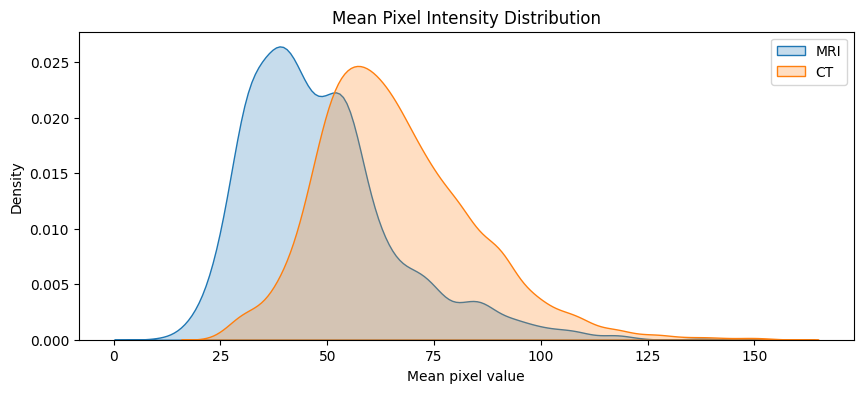

In [ ]:
def get_mean_intensity(root, modality, limit=None):
    modality_path = os.path.join(root, "Dataset", modality)
    means = []

    for label in os.listdir(modality_path):
        label_path = os.path.join(modality_path, label)
        if not os.path.isdir(label_path):
            continue

        for f in os.listdir(label_path):
            if f.lower().endswith((".jpg",".png",".jpeg")):
                img_path = os.path.join(label_path, f)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                means.append(img.mean())
                if limit and len(means) >= limit:
                    break
    return means

mri_means = get_mean_intensity(path, "Brain Tumor MRI images")
ct_means  = get_mean_intensity(path, "Brain Tumor CT scan Images")

plt.figure(figsize=(10,4))
sns.kdeplot(mri_means, label="MRI", fill=True)
sns.kdeplot(ct_means, label="CT", fill=True)
plt.title("Mean Pixel Intensity Distribution")
plt.xlabel("Mean pixel value")
plt.legend()
plt.show()


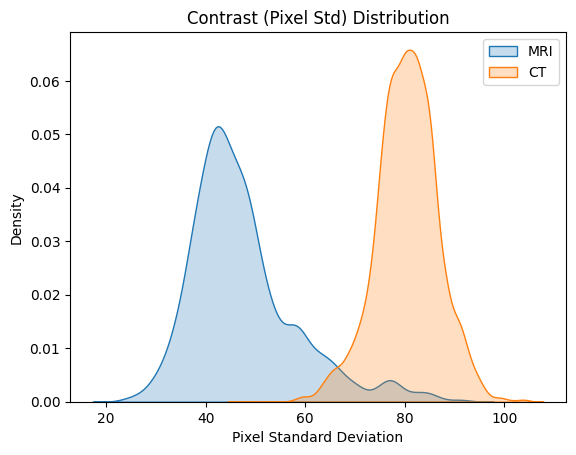

In [ ]:
def get_contrast(root, modality, limit=None):
    modality_path = os.path.join(root, "Dataset", modality)
    stds = []

    for label in os.listdir(modality_path):
        label_path = os.path.join(modality_path, label)
        if not os.path.isdir(label_path):
            continue

        for f in os.listdir(label_path):
            if f.lower().endswith((".jpg",".png",".jpeg")):
                img_path = os.path.join(label_path, f)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                stds.append(img.std())
                if limit and len(stds) >= limit:
                    break
    return stds

mri_std = get_contrast(path, "Brain Tumor MRI images")
ct_std  = get_contrast(path, "Brain Tumor CT scan Images")

sns.kdeplot(mri_std, label="MRI", fill=True)
sns.kdeplot(ct_std, label="CT", fill=True)
plt.title("Contrast (Pixel Std) Distribution")
plt.xlabel("Pixel Standard Deviation")
plt.legend()
plt.show()


To evaluate the informativeness of each modality, we analyzed pixel intensity histograms and per-image contrast levels:

*   MRI images exhibit a broad distribution of intensities, indicating strong variability in tissue textures, which CNNs can learn effectively.
*   CT images show significantly narrower intensity distributions and consistently low standard deviation (i.e., low contrast), further supporting the observation that these images were heavily downsampled or normalized.

We need to be careful with out preprocessing choices especially with modality-specific normalization to avoid unintentionally biasing the model.

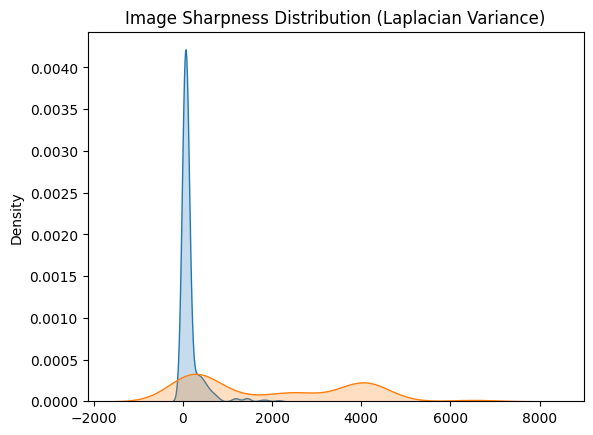

In [ ]:
def get_blur_scores(root, modality, limit=None):
    scores = []
    modality_path = os.path.join(root, "Dataset", modality)

    for label in os.listdir(modality_path):
        label_path = os.path.join(modality_path, label)
        if not os.path.isdir(label_path):
            continue

        for f in os.listdir(label_path):
            if f.lower().endswith((".jpg",".png",".jpeg")):
                img = cv2.imread(os.path.join(label_path, f), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                lap = cv2.Laplacian(img, cv2.CV_64F).var()
                scores.append(lap)
                if limit and len(scores) >= limit:
                    break

    return scores

mri_blur = get_blur_scores(path, "Brain Tumor MRI images", 400)
ct_blur  = get_blur_scores(path, "Brain Tumor CT scan Images", 400)

sns.kdeplot(mri_blur, label="MRI", fill=True)
sns.kdeplot(ct_blur, label="CT", fill=True)
plt.title("Image Sharpness Distribution (Laplacian Variance)")
plt.show()


We computed Laplacian variance to quantify blur or loss of spatial detail:

*   MRI scans maintain moderate to high sharpness across the dataset.
*   CT scans show much lower sharpness values, consistent with their reduced resolution and preprocessing artifacts.

Low-sharpness CT images may limit CNN performance and motivate exploring augmentation strategies to improve robustness.

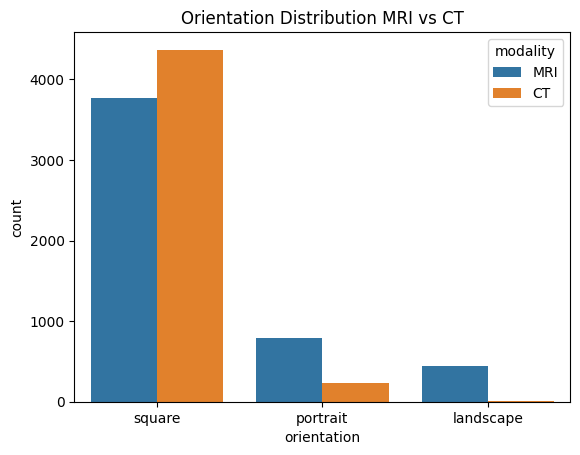

In [ ]:
df_sizes["orientation"] = df_sizes.apply(
    lambda row: "landscape" if row["width"] > row["height"]
                else "portrait" if row["width"] < row["height"]
                else "square",
    axis=1
)

sns.countplot(data=df_sizes, x="orientation", hue="modality")
plt.title("Orientation Distribution MRI vs CT")
plt.show()


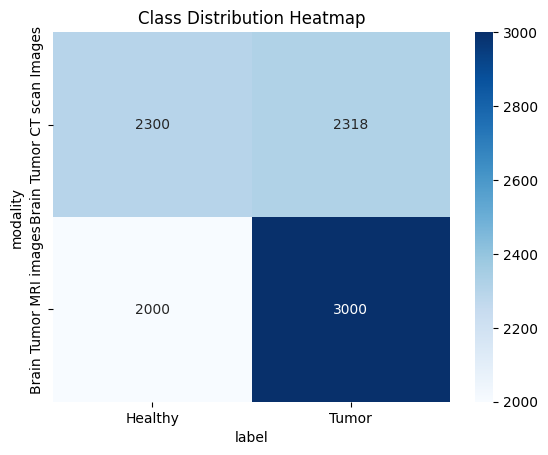

In [ ]:
pivot = df_counts.pivot(index="modality", columns="label", values="count")
sns.heatmap(pivot, annot=True, fmt="d", cmap="Blues")
plt.title("Class Distribution Heatmap")
plt.show()


MRI Scan Analysis

The MRI images in the dataset show a wide and natural variation in image resolution, ranging approximately from 200 to 1400 pixels in both width and height. This variability is typical for real MRI data collected across different hospitals, scanners, acquisition protocols, and field strengths. The MRI resolution distribution displays a broad spread, and the aspect ratio distribution is consistent with real axial or sagittal MRI slices.

These properties suggest that the MRI images are relatively raw and unprocessed, preserving much of their original clinical detail. This also means that MRI data will require standardization preprocessing before model training, including resizing, normalization, and optional augmentation. Because MRI images exhibit large variation and high resolution, they are likely to contain more informative structural patterns for tumor detection.

CT Scan Analysis

In contrast, the CT images in the dataset exhibit a much smaller and more restricted range of image dimensions, typically between 100 and 230 pixels in width and height. Unlike MRI scans, real clinical CT images normally have a standardized size of 512×512 pixels, with consistent aspect ratios and pixel spacing. The dramatically reduced resolution and inconsistent dimensions indicate that these CT images are not original CT slices, but rather cropped or downsampled thumbnails created by the dataset uploader.

This is further confirmed by the width–height scatter plots, where CT images cluster tightly in the lower-left corner, showing very limited variation compared to MRI. These findings imply that the CT images have undergone substantial preprocessing, but it is more likely cropping around regions of interest, aggressive resizing, or conversion to low-resolution PNGs. As a result, the CT images contain far less pixel information and may not reliably represent full radiologic structures.

Resources:
*   https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection
*   https://medium.com/@juanabascal78/exploratory-image-analysis-part-1-advanced-density-plots-19b255075dbd
*   https://www.datacamp.com/tutorial/seeing-like-a-machine-a-beginners-guide-to-image-analysis-in-machine-learning

